<h1 style="font-size:30px;">Linear Regression to Deep Learning using PyTorch</h1>

In this notebook, we will continue with the topic of linear regression, and we will work with the Auto-MPG dataset that contains multiple input features. The Auto-MPG dataset contains `398` sample instances and `7` features that can help us analyze and predict continuous value outcomes.

First, we will construct and train a single-layer neural network that incorporates a single input feature. From there, we will advance to performing a multi-variate linear regression, considering multiple input features. Next, we will explore how adding hidden layers in the network with non-linear activation functions will produce a non-linear response.


<img src='https://opencv.org/wp-content/uploads/2023/06/c3_02_NB03_linear_regression_cover.jpg' width="80%">

## Table of Contents

* [1 Load and Pre-Process the Auto MPG Dataset](#1-Load-and-Explore-the-Auto-MPG-Dataset)
* [2 PyTorch Training Workflow](#2-Keras-Training-Workflow)
* [3 Linear Regression](#3-Linear-Regression)
* [4 Multivariate Linear Regression](#4-Multivariate-Linear-Regression)
* [5 Deep Learning with a Single Feature](#5-Deep-Learning-with-a-Single-Feature)
* [6 Deep Learning with Multiple Features](#6-Deep-Learning-with-Multiple-Features)
* [7 Comparison of Test Results](#7-Comparison-of-Test-Results)
* [8 Conclusion](#8-Conclusion)

Let's  start by importing all the functions and classes we will use in this notebook.

In [ ]:
# Import necesary support libraries.
import os
import numpy as np
import random
import requests
import math
import warnings
from IPython.display import clear_output
from zipfile import ZipFile, BadZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# To download the dataset.
from urllib.request import urlretrieve

# Necessary PyTorch imports.
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# from torchinfo import summary

# Set plotting related parameters.
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 12

warnings.filterwarnings(action='ignore', category=UserWarning)

# Text formatting
BOLD = "\033[1m"
END = "\033[0m"

In [ ]:
def system_config(SEED_VALUE=42, package_list=None):
    """
    Configures the system environment for PyTorch-based operations.

    Args:
        SEED_VALUE (int): Seed value for random number generation. Default is 42.
        package_list (str): String containing a list of additional packages to install
        for Google Colab or Kaggle. Default is None.

    Returns:
        tuple: A tuple containing the device name as a string and a boolean indicating GPU availability.
    """

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)

    def is_running_in_colab():
        return 'COLAB_GPU' in os.environ

    def is_running_in_kaggle():
        return 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

    #--------------------------------
    # Check for the availability GPUs.
    #--------------------------------
    if torch.cuda.is_available():
        print('Using CUDA GPU')

        # This section for installing packages required by Colab.
        if is_running_in_colab() or is_running_in_kaggle():
            print('Installing required packages...')
            !pip install {package_list}

        # Set the device to the first CUDA device.
        DEVICE = torch.device('cuda')
        print("Device: ", DEVICE)
        GPU_AVAILABLE = True

        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)

        # Performance and deterministic behavior.
        torch.backends.cudnn.enabled = True       # Provides highly optimized primitives for DL operations.
        torch.backends.cudnn.deterministic = True # Insures deterministic even when above cudnn is enabled.
        torch.backends.cudnn.benchmark = False    # Setting to True can cause non-deterministic behavior.

    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        print('Using Apple Silicon GPU')

        # Set the device to the Apple Silicon GPU Metal Performance Shader (MPS).
        DEVICE = torch.device("mps")
        print("Device: ", DEVICE)
        # Environment variable that allows PyTorch to fall back to CPU execution
        # when encountering operations that are not currently supported by MPS.
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        GPU_AVAILABLE = True

        torch.mps.manual_seed(SEED_VALUE)
        torch.use_deterministic_algorithms(True)

    else:
        print('Using CPU')
        DEVICE = torch.device('cpu')
        print("Device: ", DEVICE)
        GPU_AVAILABLE = False

        if is_running_in_colab() or is_running_in_kaggle():
            print('Installing required packages...')
            !pip install {package_list}
            print('Note: Change runtime type to GPU for better performance.')

        torch.use_deterministic_algorithms(True)

    return str(DEVICE), GPU_AVAILABLE

In [ ]:
# Additional packages required for Google Colab or Kaggle.
package_list = "torchinfo"

DEVICE, GPU_AVAILABLE = system_config(package_list=package_list)

Using CPU
Device:  cpu
Installing required packages...
Note: Change runtime type to GPU for better performance.


In [ ]:
from torchinfo import summary

## 1 Load and Pre-Process the Auto MPG Dataset

In this notebook, we will be working with the Auto MPG dataset from the UC Irvine machine learning repository [here](https://archive.ics.uci.edu/ml/datasets.php). This data set contains nearly 400 samples of automobile data from the 1970s. There are eight data fields in the dataset consisting of various attributes such as vehicle weight and horsepower, and the goal is to use these features to *predict the vehicle MPG.*

In [ ]:
def download_file(url, save_name):
    response = requests.get(url, stream=True)
    with open(save_name, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print(f"Downloaded: {save_name}")

In [ ]:
def unzip(zip_file_path=None):
    try:
        with ZipFile(zip_file_path, 'r') as z:
            z.extractall("./")
            print(f"Extracted: {os.path.splitext(zip_file_path)[0]}\n")
    except FileNotFoundError:
        print("File not found")
    except BadZipFile:
        print("Invalid or corrupt zip file")
    except Exception as e:
        print(f"Error occurred: {e}")

    return

In [ ]:
URL = r"https://www.dropbox.com/scl/fi/dthi5o1822ayfb6wkqhnz/data_auto_mpg.zip?rlkey=hbyo3ndrdbissft57yt89wmak&dl=1"

archive_name = "data_auto_mpg"

zip_name = f"./{archive_name}.zip"

if not os.path.exists(archive_name):

    download_file(URL, zip_name)
    unzip(zip_name)

Downloaded: ./data_auto_mpg.zip
Extracted: ./data_auto_mpg



In [ ]:
column_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin"]

# Load the dataset into a Pandas data frame.
raw_dataset = pd.read_csv(
    os.path.join(archive_name,"./auto-mpg.data"),
    names=column_names,
    na_values="?",
    comment="\t",
    sep=" ",
    skipinitialspace=True,
)

dataset = raw_dataset.copy()
print(dataset.tail())
dataset.columns

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1  


Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'Origin'],
      dtype='object')

### 1.1 Clean the Dataset

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
# Use the dropna() method to remove data samples that are not fully populated.
dataset = dataset.dropna()
dataset.shape

(392, 8)

### 1.2 Split the Dataset into Train and Test

Let's now split the dataset into test and train components so we can train some models and evaluate them.

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset  = dataset.drop(train_dataset.index)

print(train_dataset.shape)
print(test_dataset.shape)

(314, 8)
(78, 8)


In [ ]:
train_dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
79,26.0,4,96.0,69.0,2189.0,18.0,72,2
276,21.6,4,121.0,115.0,2795.0,15.7,78,2
248,36.1,4,91.0,60.0,1800.0,16.4,78,3
56,26.0,4,91.0,70.0,1955.0,20.5,71,1
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
...,...,...,...,...,...,...,...,...
218,36.0,4,79.0,58.0,1825.0,18.6,77,2
281,19.8,6,200.0,85.0,2990.0,18.2,79,1
342,30.0,4,135.0,84.0,2385.0,12.9,81,1
238,33.5,4,98.0,83.0,2075.0,15.9,77,1


In [ ]:
test_dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
13,14.0,8,455.0,225.0,3086.0,10.0,70,1
20,25.0,4,110.0,87.0,2672.0,17.5,70,2
21,24.0,4,107.0,90.0,2430.0,14.5,70,2
35,17.0,6,250.0,100.0,3329.0,15.5,71,1
...,...,...,...,...,...,...,...,...
381,36.0,4,107.0,75.0,2205.0,14.5,82,3
388,26.0,4,156.0,92.0,2585.0,14.5,82,1
391,36.0,4,135.0,84.0,2370.0,13.0,82,1
395,32.0,4,135.0,84.0,2295.0,11.6,82,1


### 1.3 Split the Features from Target Values

Since the features and the target value are contained in the same dataframe we will separate them into two dataframes to keep them isolated. This also makes it easier to manage the data.

In [ ]:
X_train = train_dataset.copy()
X_test  = test_dataset.copy()

# Separate target values from features.
y_train = X_train.pop('MPG')
y_test  = X_test.pop('MPG')

## 2 PyTorch Training Workflow

The diagram shown below summarizes the training workflow in PyTorch that is used to create a trained model.

<img src="https://opencv.org/wp-content/uploads/2023/06/c3_02_NB03_linear_regression_Training_workflow.jpg" width="50%" align='center'>

1. We begin by defining a PyTorch model using `torch.nn.Module`.

2. Next, we define the optimizer and loss criterion to use on the dataset.

3. The training loop consits of 5 main lines of code which you'll find in any PyTorch based project.

    1. Generate predictions using the model: `out = model(input_data)`

    2. Clear any previously calculated gradients (is effective starting from the second pass through the model).
    
    3. Calculate the loss: `loss = loss_fn(out, target)`
    
    4. Calculate gradients of the parameter based on the `loss: loss.backward()`
    
    5. Finally, we update the model parameters: `optimizer.step()`.

## 3 Linear Regression

**Linear regression** is a statistical method and a type of predictive modelling technique. It investigates the relationship between a dependent (target) variable and one (simple linear regression) or more (multiple linear regression) independent variables. The relationships are modeled using linear predictor functions where the unknown parameters are estimated from the data. The linear model is used to predict output based on the weighted sum of the input features. The output in this case, is a real-valued number:

$$ h_\theta(x) = y' = \theta_0 + \theta_1x_1 + \theta_2x_2 + ...$$

The general notation can be simplified to the following by letting $x_0 = 1$ which means that $\theta_0$ becomes the bias term, and therefore the above expression can be simplified as follows:

$$ h(x) = y' = \sum_{i=0}^{n} \theta_ix_i = \theta^Tx $$


Where,
* $x_0 ... x_n$ are input features or independent variables.

* $\theta_0 ... \theta_n$ are the parameters/weights of the linear model.

* $y'$ is a real-valued predicted target variable in a regression problem.


---

In this section, we will create a PyTorch model with a single output neuron (using a linear activation) to perform linear regression. We will only use a single input variable from the dataset.

Specifically, we'll use `Horsepower` as the input feature to predict the `MPG` of the vehicle. Thus, the model will be a straight line with two unknown coefficients (the slope and the intercept). We will train the model to determine the coefficients.

$$ h_\theta(x) = y' = \theta_0 + \theta_1x_1$$

When working with neural networks, it is more common to use the notation below:

$$ y' = b + w_1x_1$$

### 3.1 Normalize the Feature Data

As mentioned above, this dataset contains a wide range of feature values, and often in machine learning and deep learning it is recommended to scale features so that they span a similar value range. One reason this is important is that the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. Although a model might converge without feature scaling, scaling features makes training much more stable and also facilitates the optimization process by allowing gradient descent to converge much faster.

Various methods can be used to scale features, but normalization and standardization are the most commonly used methods. Normalization usually refers to min/max scaling, where each feature is scaled to the range \[0, 1\] as shown below for each feature ($x_i$):

$$ x_i = \frac{x_i - min_{x_i}}{max_{x_i} - min_{x_i}}$$


Standardization (also referred to as z-score scaling) assume the original data is normally distributed and scales the feature to have zero mean and a standard deviation of 1. This is accomplished for each feature ($x_i$) by subtracting the mean of the feature data from each data point (referred to as mean subtraction) and then dividing that result by the standard deviation for the feature data as shown below:

$$ x_i = \frac{x_i - \mu_i}{\sigma_i}$$

In the code cell below, we are using numpy to calculate the mean and standard deviation for the `Horsepower` and `Displacement` features of the training dataset which are then used to normalize the data.

**Note**: The normalization parameters (mean and standard deviation) are derived only from the **training** dataset, but will be applied to all of the data (train, validation and test).

In [ ]:
# Calculate mean and standard deviation for Horsepower

mean_hp = np.mean(X_train['Horsepower'])
std_hp  = np.std(X_train['Horsepower'])

print("\nFor 'Horsepower' column:")
print("Mean:  ", mean_hp)
print("Std:   ", std_hp)
print("Count: ", X_train.shape[0])

# Scale Horsepower feature
X_train["Horsepower_scaled"] = (X_train["Horsepower"] - mean_hp) / std_hp
X_test["Horsepower_scaled"]  = (X_test["Horsepower"]  - mean_hp) / std_hp

# Calculate mean and standard deviation for Displacement
mean_dis = np.mean(X_train["Displacement"])
std_dis  = np.std(X_train["Displacement"])

print("\nFor 'Displacement' column:")
print("Mean:  ", mean_dis)
print("Std:   ", std_dis)
print("Count: ", X_train.shape[0])

# Scale Displacement feature
X_train["Displacement_scaled"] = (X_train["Displacement"] - mean_dis) / std_dis
X_test["Displacement_scaled"]  = (X_test["Displacement"] -  mean_dis) / std_dis


For 'Horsepower' column:
Mean:   105.97133757961784
Std:    39.57339154776915
Count:  314

For 'Displacement' column:
Mean:   197.85509554140128
Std:    106.33217177453977
Count:  314


### 3.2 Create PyTorch Model

Here we define the PyTorch model. The figure below shows the model architecture.


<img src='https://opencv.org/wp-content/uploads/2023/06/c3_02_NB03_linear_regression_DL_high_level.png' width=600 align='center'><br/>

Note: The weight update process includes the bias term even though an update equations is not explciity shown in the figure.

In [ ]:
class Regressor_1(nn.Module):
    # Initialize the parameter.
    def __init__(self, in_features=1, out_features=1):
        super().__init__()

        # Define a single Linear layer.
        self.linear_1 = nn.Linear(in_features=in_features, out_features=out_features)

    # Forward pass
    def forward(self, x):
        return self.linear_1(x)

In [ ]:
# Intialize an instance of the PyTorch model class.
linear_1d_model = Regressor_1(in_features=1, out_features=1)

batch_size = 1
summary(linear_1d_model, input_size=(batch_size, 1,), device="cpu", col_names=("input_size", "output_size", "num_params"))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Regressor_1                              [1, 1]                    [1, 1]                    --
├─Linear: 1-1                            [1, 1]                    [1, 1]                    2
Total params: 2
Trainable params: 2
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [ ]:
# Initialize Optimizer by passing the parameters of the model and the learning rate to use.
# The model parameters passed to the optimizer will be updated during training.
optimizer = optim.Adam(linear_1d_model.parameters(), lr=0.1)

# Intialize a Loss function.
# Here we are using L1Loss that measures the mean absolute error (MAE) between the input x and target y.
criterion = torch.nn.L1Loss()

### 3.3 Train the Model

It's now time to train the model using the single input feature. The training data is split into 70% training and 30% validation, to evaluate the model's performance during the training process.

In [ ]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [ ]:
# To record the traning and validation loss metrics.
loss_curve_train_linear_1d = []
loss_curve_eval_linear_1d  = []

X_train_hp = torch.from_numpy(X_train_split["Horsepower_scaled"].values).reshape(-1, 1).to(torch.float32)
y_train_t = torch.from_numpy(y_train_split.values).reshape(-1, 1).to(torch.float32) # Train target converted to pytorch tensor.

X_val_hp = torch.from_numpy(X_val_split["Horsepower_scaled"].values).reshape(-1, 1).to(torch.float32)
y_val_t    = torch.from_numpy(y_val_split.values).reshape(-1, 1).to(torch.float32) # Validation target converted to pytorch tensor.


# This is the training loop. We will go through the dataset 500 times.
# During each pass the model will be updated and get closer to the true target values.
for epoch in range(500):

    linear_1d_model.train() # Set model in training mode.
                            # Not required here as the layers used behave the same way during trainig and evaluation

    output = linear_1d_model(X_train_hp) # Perform forward pass through the model.
    loss = criterion(output, y_train_t)  # Calculate L1 loss on the model predictions.
    optimizer.zero_grad()                # Reset gradients.
    loss.backward()                      # Calcualte gradients based on the loss.
    optimizer.step()                     # Update parameters.

    loss_curve_train_linear_1d.append(loss.detach().item()) # Record training loss.


    linear_1d_model.eval() # Set model in evaluation mode.

    with torch.no_grad():
        output = linear_1d_model(X_val_hp) # Perform forward pass through the validation set.

    loss = criterion(output, y_val_t) # Calculate the loss on the validation set.
    loss_curve_eval_linear_1d.append(loss.item()) # Record validation loss.

    # # Print per epoch log table.
    # # Slows down speed because we are printing and erasing the table continuously.
    # clear_output(wait=True)
    # print(f"{BOLD}{'Epoch':^10}{END}|{BOLD}{'Loss':^15}{END}|{BOLD}{'Val_loss':^10}{END}")
    # print(f"{'':=^35}")
    # print(f"{epoch+1:^10}|{loss_curve_train_linear_1d[-1]:^15.8f}|{loss_curve_eval_linear_1d[-1]:^10.3f}")

In [ ]:
def plot_loss(loss_curve_train, loss_curve_eval):
    plt.figure(figsize=(15, 5))
    plt.plot(loss_curve_train, label="Loss")
    plt.plot(loss_curve_eval, label="Val Loss")
    plt.ylim([0, 30])
    plt.xlabel("Epoch")
    plt.ylabel("Error [MPG]")
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()
    return

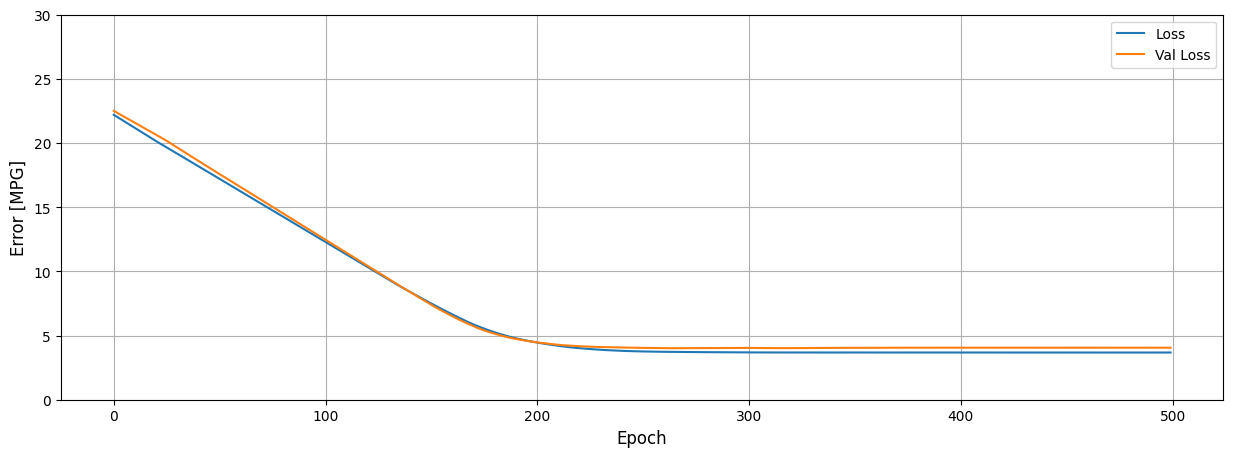

In [ ]:
plot_loss(loss_curve_train_linear_1d, loss_curve_eval_linear_1d)

In [ ]:
hist = pd.DataFrame(
    {
        "loss":     loss_curve_train_linear_1d,
        "val_loss": loss_curve_eval_linear_1d,
    }
)

hist.describe()

,loss,val_loss
count,500.000000,500.000000
mean,7.256331,7.519203
std,5.508316,5.528823
min,3.677526,4.015281
25%,3.677597,4.051866
50%,3.762090,4.057088
75%,9.841221,9.917352
max,22.202372,22.510668


Training and validation statistics are very close to each other which is a good sign because it tells us that the model can generalize to unseen data as well.

### 3.4 Model Prediction

Once the model has been trained, we can now use it to predict `MPG` given a range of values for `Horsepower`.

In [ ]:
# # Generate feature data for Horsepower.
x = torch.linspace(X_train["Horsepower"].min(), X_train["Horsepower"].max(), len(X_train["Horsepower"]))

# Use the model to predict MPG.
linear_1d_model.eval()

with torch.no_grad():
    y = linear_1d_model((x.view(-1, 1) - mean_hp) / std_hp)

In [ ]:
def plot_horsepower(x, y):
    plt.figure(figsize=(15, 5))

    plt.scatter(
        (X_train["Horsepower_scaled"] * std_hp) + mean_hp,
        y_train,
        label="Data",
        color="green",
        alpha=0.5,
    )
    plt.plot(x, y, color="k", label="Predictions")
    plt.xlabel("Horsepower")
    plt.ylabel("MPG")
    plt.grid(True)
    plt.legend()

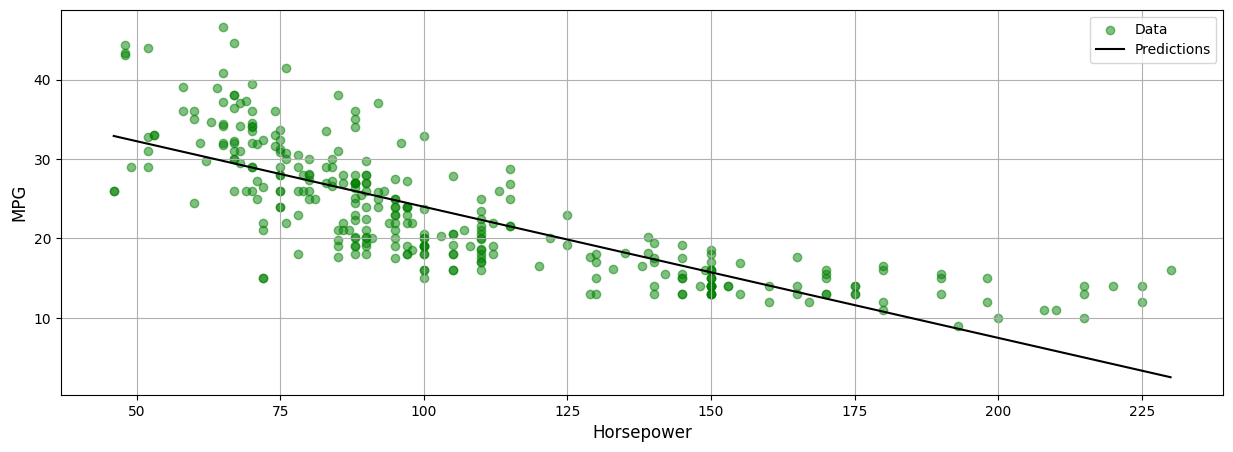

In [ ]:
plot_horsepower(x.view(-1, 1).numpy(), y.numpy())

## 4 Multivariate Linear Regression

In this section, we will extend the previous example to now use two input features. All of the processing steps will remain the same. The only differences are those related to the input shape. With two input features, our model for the response variable is now a plane rather than a line. Using the general form that we introduced in Module 1, the hypothesis (function) takes the following form with two input features:

$$ h_\theta(x) = \theta_0 + \theta_1x_1 + \theta_2x_2$$

When working with neural networks, it is more common to use the notation below:

$$ y' = w_1x_1 + w_2x_2 + b$$

Since we have two inputs, we have two weights (one for each input) and then a single bias term associated with the single neuron. The equations above represent the equation of a plane in 3D space.

### 4.1 Intialize Model, Optimizer & Loss function

In [ ]:
linear_2d_model = Regressor_1(in_features=2, out_features=1)

batch_size = 1
summary(linear_2d_model, input_size=(batch_size, 2,), device="cpu", col_names=("input_size", "output_size", "num_params"))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Regressor_1                              [1, 2]                    [1, 1]                    --
├─Linear: 1-1                            [1, 2]                    [1, 1]                    3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [ ]:
# Initialize Optimizer and loss function.

optimizer = optim.Adam(linear_2d_model.parameters(), lr=0.1)
criterion = torch.nn.L1Loss()

### 4.2 Train the Model

In this section, we will first define two small helper functions `train_one_epoch(...)` and `evaluate(...)` to perform training and evaluate the model during each training loop. By creating these function, it's help reduce redundant code and help avoid making mistakes that can happen during code updation.

We also define one more function `generate_predictions(...)` that ensures the model runs in evaluation mode.

The `evaluate(..)` and `generate_predictions(...)` make use of <a href="https://pytorch.org/docs/stable/generated/torch.no_grad.html" target="_blank">torch.no_grad()</a> and <a href="https://pytorch.org/docs/stable/generated/torch.inference_mode.html" target="_blank">torch.inference_mode()</a> to ensure no gradients are tracked or calculated during inference.

In [ ]:
def train_one_epoch(model: torch.nn.Module, optimizer: torch.optim.Optimizer, loss_fn: torch.nn.Module, dataset: tuple):

    data, target = dataset
    model.train() # Set model in training mode.

    outputs = model(data)           # Perform forward pass through the model.
    loss = loss_fn(outputs, target) # Calculate L1 loss on the model predictions.
    optimizer.zero_grad()           # Reset gradients.
    loss.backward()                 # Calcualte gradients based on the loss.
    optimizer.step()                # Update parameters.

    return loss.detach().item()

def evaluate(model: torch.nn.Module, loss_fn: torch.nn.Module, dataset: tuple):

    data, target = dataset

    model.eval() # Set model in evaluation mode.

    with torch.no_grad():
        outputs = model(data) # Perform forward pass through the validation set.

    loss = loss_fn(outputs, target) # Calculate the loss on the validation set.

    return loss.item()

@torch.inference_mode()
def generate_predictions(model, data):
    model.eval()

    outputs = model(data)

    return outputs

In [ ]:
# Initialize the 2-feature dataset. The targets remain the same.

X_train_hp_dp = torch.from_numpy(X_train_split[['Horsepower_scaled','Displacement_scaled']].values).reshape(-1, 2).to(torch.float32)
X_val_hp_dp   = torch.from_numpy(X_val_split[['Horsepower_scaled', 'Displacement_scaled']].values).reshape(-1, 2).to(torch.float32)

We also use the `tqdm` package to display a progress bar indicating the number of epochs completed along with the time required to finish.

In [ ]:
from tqdm import trange

# To record the traning and validation loss metrics.
loss_curve_train_linear_2d = []
loss_curve_eval_linear_2d  = []

for epoch in trange(500):

    # Perform one epoch of training and then evaluate on the validation set.
    train_loss = train_one_epoch(linear_2d_model, optimizer, criterion, (X_train_hp_dp, y_train_t))
    val_loss   = evaluate(linear_2d_model, criterion, (X_val_hp_dp, y_val_t))

    # Record training and validation loss
    loss_curve_train_linear_2d.append(train_loss)
    loss_curve_eval_linear_2d.append(val_loss)

100%|██████████| 500/500 [00:01<00:00, 397.93it/s]


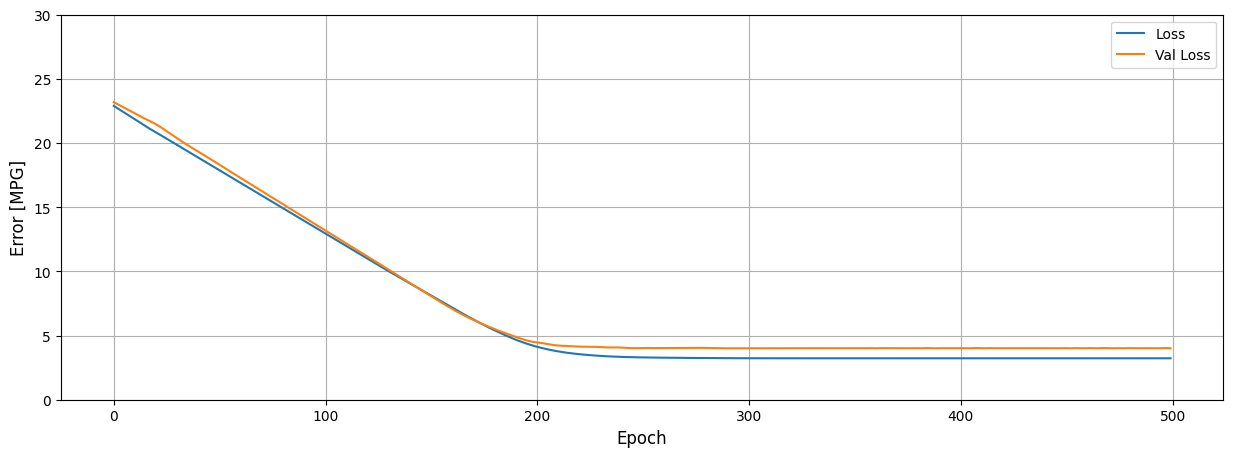

In [ ]:
plot_loss(loss_curve_train_linear_2d, loss_curve_eval_linear_2d)

### 4.3 Visualize the Trained Model

In [ ]:
hp_min = (X_train.Horsepower_scaled.min()   * std_hp)  + mean_hp
hp_max = (X_train.Horsepower_scaled.max()   * std_hp)  + mean_hp
dp_min = (X_train.Displacement_scaled.min() * std_dis) + mean_dis
dp_max = (X_train.Displacement_scaled.max() * std_dis) + mean_dis

x_surf, y_surf = np.meshgrid(np.linspace(hp_min, hp_max, 100), np.linspace(dp_min, dp_max, 100))

x_grid = pd.DataFrame(
    {
        'Horsepower':   (x_surf.ravel() - mean_hp) / std_hp,
        'Displacement': (y_surf.ravel() -mean_dis) / std_dis,
     }
)

pred_y = generate_predictions(linear_2d_model, data=torch.from_numpy(x_grid.values).view(-1,2).float()).numpy()

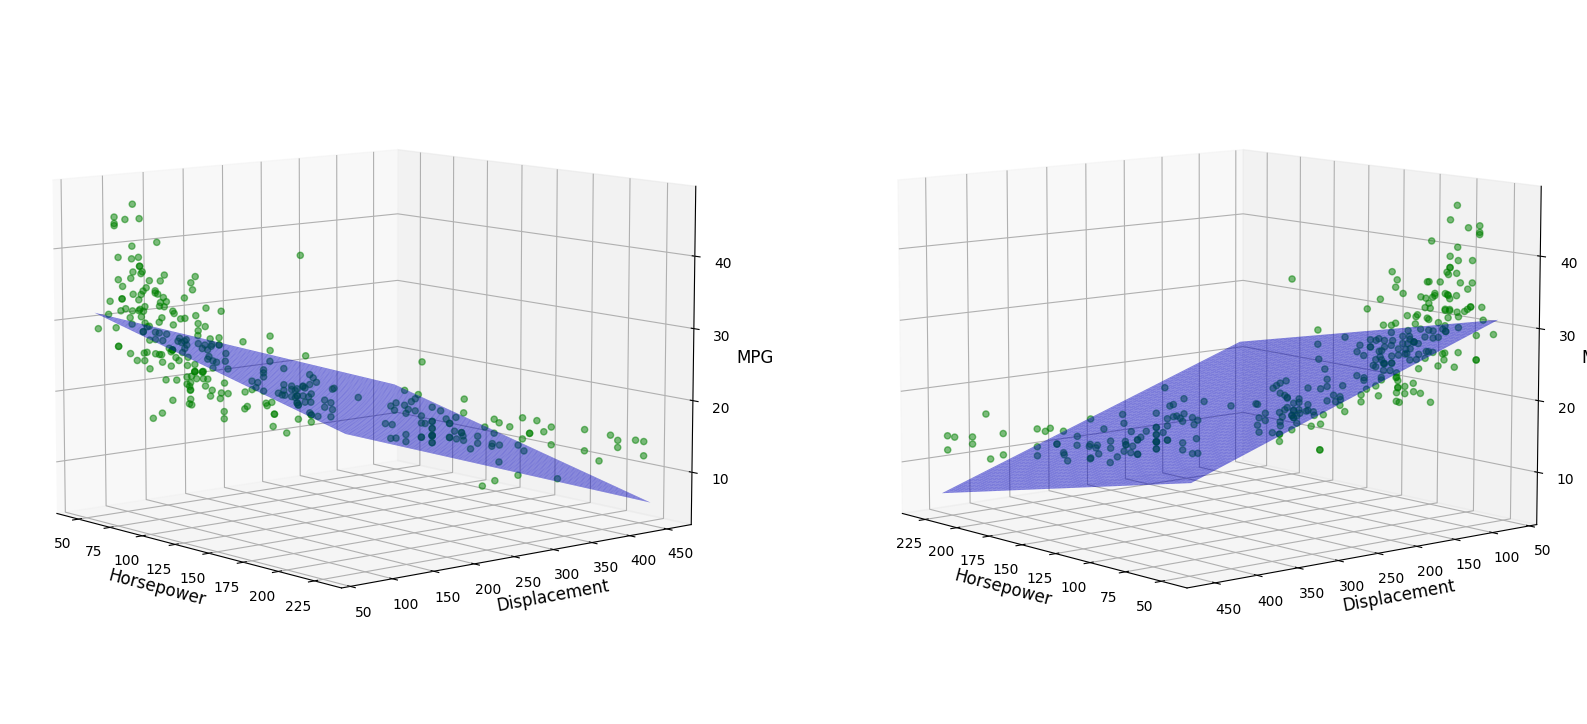

In [ ]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(121, projection='3d')
ax.scatter((X_train['Horsepower_scaled'] * std_hp) + mean_hp, (X_train['Displacement_scaled'] * std_dis) + mean_dis, y_train, c='green', marker='o', alpha=0.5)
ax.plot_surface(x_surf, y_surf, pred_y.reshape(x_surf.shape), color='blue', alpha=0.5)
ax.set_xlabel('Horsepower')
ax.set_ylabel('Displacement')
ax.set_zlabel('MPG')
ax.view_init(9, -40)

ax = fig.add_subplot(122, projection='3d')
ax.scatter((X_train['Horsepower_scaled'] * std_hp) + mean_hp, (X_train['Displacement_scaled'] * std_dis) + mean_dis, y_train, c='green', marker='o', alpha=0.5)
ax.plot_surface(x_surf, y_surf, pred_y.reshape(x_surf.shape), color='blue', alpha=0.5)
ax.set_xlabel('Horsepower')
ax.set_ylabel('Displacement')
ax.set_zlabel('MPG')
ax.view_init(9, 140)

## 5 Deep Learning with a Single Feature

We are now ready to model hidden layers in our network. Adding hidden layers with non-linear activation functions is what makes them "Deep" and capable of learning general non-linear functional mappings between inputs and outputs. The simplified network diagram below shows the general architecture, which consists of an input layer, two hidden layers, and the output layer. In this section, we are going to model a network like this using single input feature. We will use a non-linear (`relu`) activation function in the hidden layers that will allow the network to model non-linear functions.

<img src='https://opencv.org/wp-content/uploads/2023/06/c2_m01_DL_high_level.png' width=700 align='center'><br/>

### 5.1 Build the PyTorch Model

Here we are going to build a simple deep neural network with two hidden layers (each with 32 neurons). Each of the neurons in the hidden layers will use `relu` activation functions. The choice of two hidden layers and 32 neurons for each layer is rather arbitrary, but we will need at least one hidden layer to model a non-linear response.

In [ ]:
class Regressor_2(nn.Module):

    # Initialize the parameter
    def __init__(self, in_features=2, out_features=1, intermediate=10):
        super().__init__()

        self.linear_1 = nn.Linear(in_features=in_features,  out_features=intermediate)
        self.linear_2 = nn.Linear(in_features=intermediate, out_features=intermediate)
        self.linear_3 = nn.Linear(in_features=intermediate, out_features=out_features)

    # Forward pass
    def forward(self, x):
        # First Linear layer --=> ReLU activation
        pred = F.relu(self.linear_1(x))

        # Second Linear layer --=> ReLU activation
        pred = F.relu(self.linear_2(pred))

        # Third Linear layer.
        pred = self.linear_3(pred)
        return pred

Display the initial values for the weights and biases in the first hidden layer.

In [ ]:
dnn_1d_model = Regressor_2(in_features=1, out_features=1, intermediate=32)

batch_size = 1
summary(dnn_1d_model, input_size=(batch_size, 1,), device="cpu", col_names=("input_size", "output_size", "num_params"))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Regressor_2                              [1, 1]                    [1, 1]                    --
├─Linear: 1-1                            [1, 1]                    [1, 32]                   64
├─Linear: 1-2                            [1, 32]                   [1, 32]                   1,056
├─Linear: 1-3                            [1, 32]                   [1, 1]                    33
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

In [ ]:
# Initialize Optimizer and loss function.

optimizer = optim.Adam(dnn_1d_model.parameters(), lr=0.01)
criterion = torch.nn.L1Loss()

### 5.2 Train the Model

In [ ]:
# To record the traning and validation loss metrics.
loss_curve_train_dnn_1d = []
loss_curve_eval_dnn_1d  = []

for epoch in trange(500):

    # Perform one epoch of training and then evaluate on the validation set.
    train_loss = train_one_epoch(dnn_1d_model, optimizer, criterion, (X_train_hp, y_train_t))
    val_loss   = evaluate(dnn_1d_model, criterion, (X_val_hp, y_val_t))

    # Record training and validation loss
    loss_curve_train_dnn_1d.append(train_loss)
    loss_curve_eval_dnn_1d.append(val_loss)

100%|██████████| 500/500 [00:01<00:00, 347.99it/s]


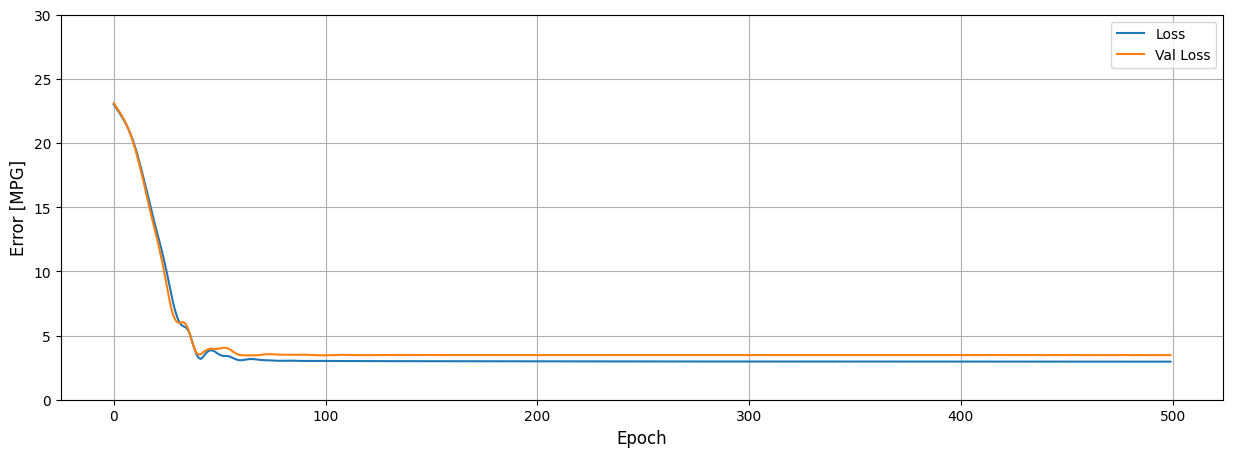

In [ ]:
plot_loss(loss_curve_train_dnn_1d, loss_curve_eval_dnn_1d)

### 5.4 Visualize the Trained Model

As you can see in the plot below, we now have a non-linear response from the neural network. In the next section we are going to add a second input feature so we an visualize the non-linear response in more than two dimensions.

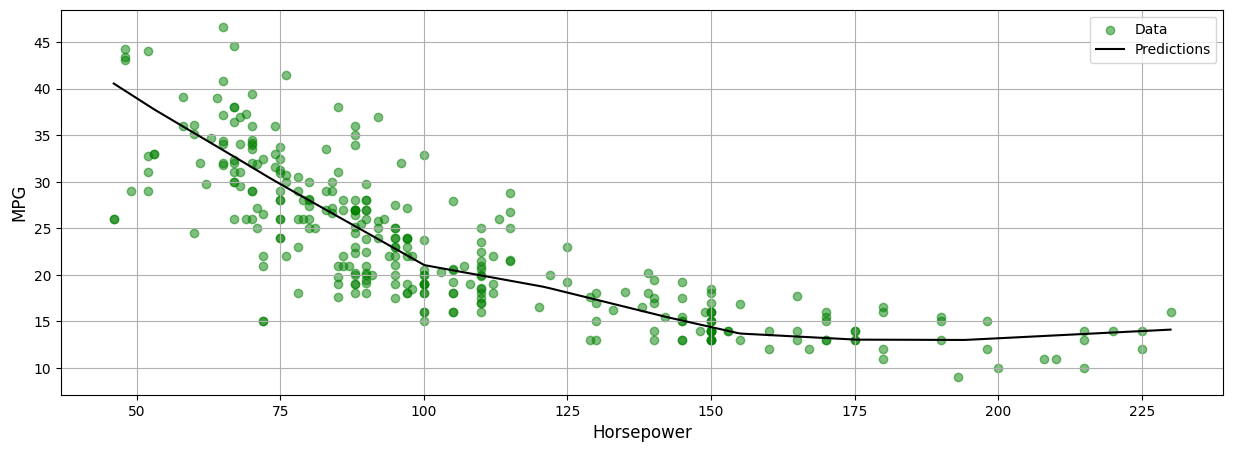

In [ ]:
x = torch.linspace(X_train["Horsepower"].min(), X_train["Horsepower"].max(), len(X_train["Horsepower"]))

y = generate_predictions(dnn_1d_model, data=((x.view(-1, 1) - mean_hp) / std_hp)).numpy()

plot_horsepower(x, y)

## 6 Deep Learning with Multiple Features

We will now introduce a second feature as we did in the Linear Regression section. This time we'll be using two input features with a deep neural network so that we can demonstrate the non-linear behavior of a neural work in more than two dimensions. When we used two input variables with just a single neuron (linear regression) the response function was a 2D plane in 3D space. This time we expect a non-linear surface in 3D space that better fits the data. Let's continue on and see!

### 6.1 Build the PyTorch Model

The model below is the same as the one in the previous section with the exception that we are using two input features instead of one.

In [ ]:
dnn_2d_model = Regressor_2(in_features=2, out_features=1, intermediate=32)

batch_size = 1

summary(dnn_2d_model, input_size=(batch_size, 2,), device="cpu", col_names=("input_size", "output_size", "num_params"))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Regressor_2                              [1, 2]                    [1, 1]                    --
├─Linear: 1-1                            [1, 2]                    [1, 32]                   96
├─Linear: 1-2                            [1, 32]                   [1, 32]                   1,056
├─Linear: 1-3                            [1, 32]                   [1, 1]                    33
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

In [ ]:
# Initialize Optimizer and loss function.

optimizer = optim.Adam(dnn_2d_model.parameters(), lr=0.01)
criterion = torch.nn.L1Loss()

In [ ]:
from tqdm import trange

# To record the traning and validation loss metrics.
loss_curve_train_dnn_2d = []
loss_curve_eval_dnn_2d  = []

for epoch in trange(500):

    # Perform one epoch of training and then evaluate on the validation set.
    train_loss = train_one_epoch(dnn_2d_model, optimizer, criterion, (X_train_hp_dp, y_train_t))
    val_loss   = evaluate(dnn_2d_model, criterion, (X_val_hp_dp, y_val_t))

    # Record training and validation loss
    loss_curve_train_dnn_2d.append(train_loss)
    loss_curve_eval_dnn_2d.append(val_loss)

100%|██████████| 500/500 [00:00<00:00, 535.25it/s]


### 6.3 Train the Model

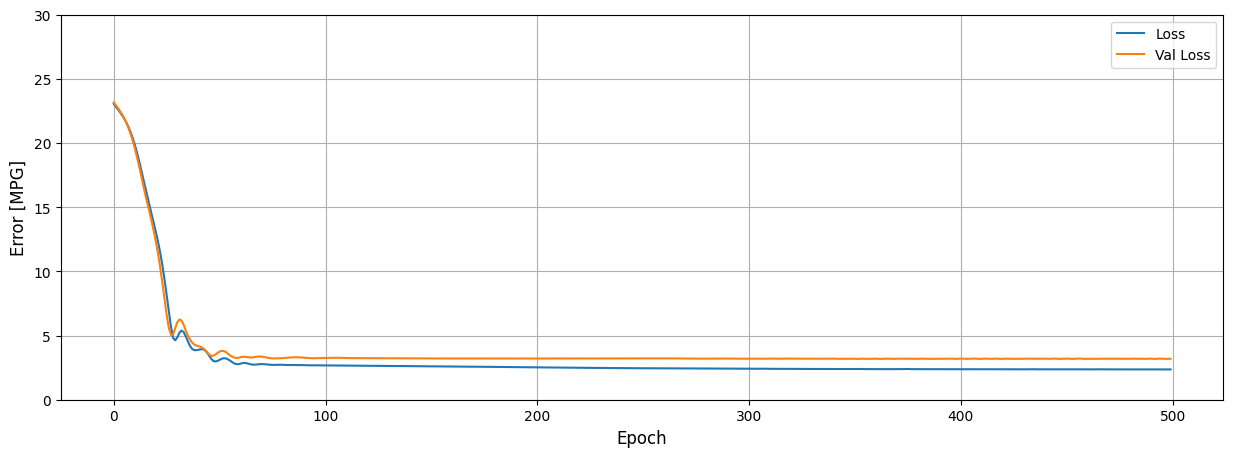

In [ ]:
plot_loss(loss_curve_train_dnn_2d, loss_curve_eval_dnn_2d)

### 6.4 Visualize the Trained Model

As shown in the plots below the response function from the network is a non-linear surface which does a better job of fitting the data.

In [ ]:
hp_min = (X_train.Horsepower_scaled.min()   * std_hp)  + mean_hp
hp_max = (X_train.Horsepower_scaled.max()   * std_hp)  + mean_hp
dp_min = (X_train.Displacement_scaled.min() * std_dis) + mean_dis
dp_max = (X_train.Displacement_scaled.max() * std_dis) + mean_dis

x_surf, y_surf = np.meshgrid(np.linspace(hp_min, hp_max, 100), np.linspace(dp_min, dp_max, 100))

x_grid = pd.DataFrame(
    {
        'Horsepower':   (x_surf.ravel() - mean_hp)  / std_hp,
        'Displacement': (y_surf.ravel() - mean_dis) / std_dis,
     }
)

pred_y = generate_predictions(dnn_2d_model, data=torch.from_numpy(x_grid.values).view(-1,2).float()).numpy()

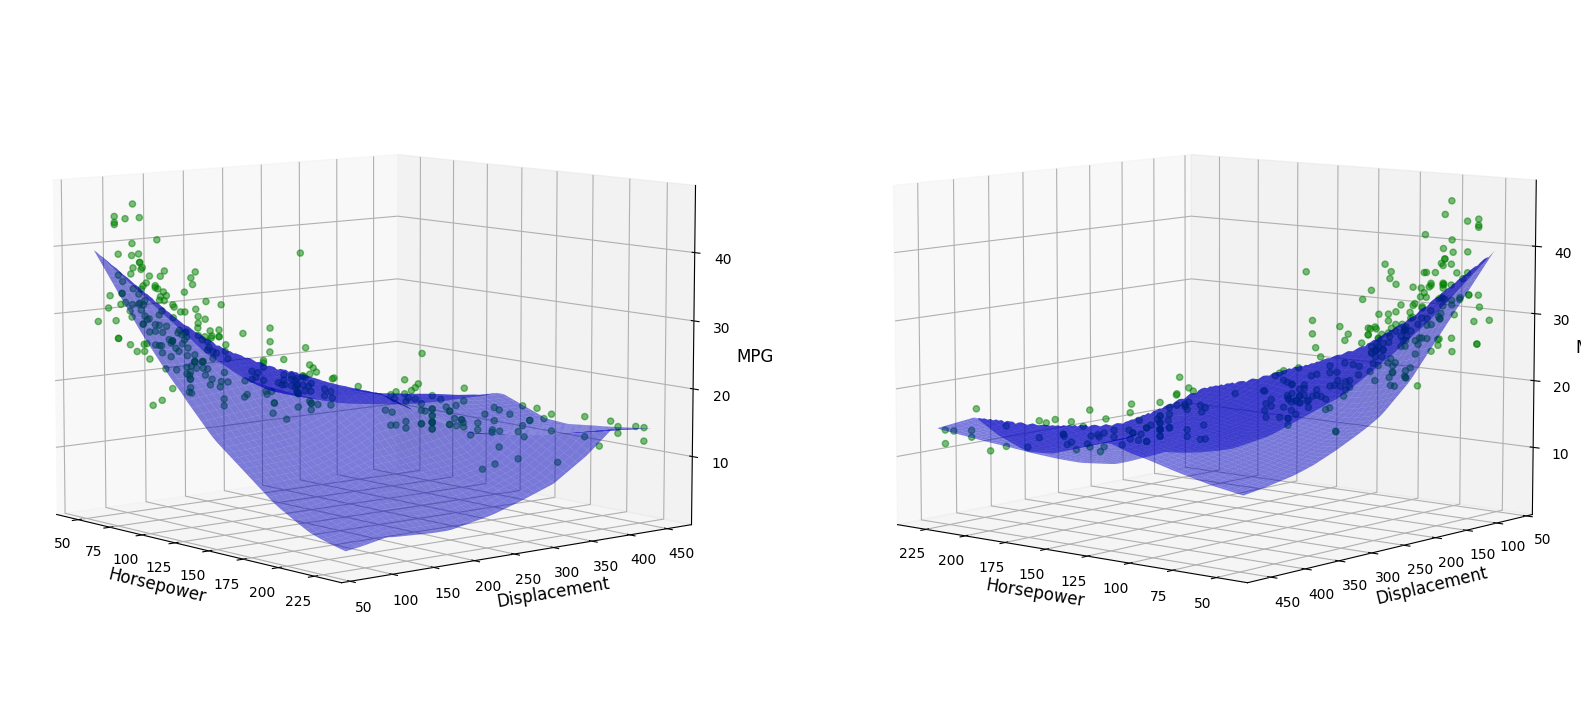

In [ ]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(
    (X_train['Horsepower_scaled'] * std_hp) + mean_hp, (X_train['Displacement_scaled'] * std_dis) + mean_dis,
    y_train,
    c='green',
    marker='o',
    alpha=0.5
)
ax.plot_surface(x_surf, y_surf, pred_y.reshape(x_surf.shape), color='blue', alpha=0.5)
ax.set_xlabel('Horsepower')
ax.set_ylabel('Displacement')
ax.set_zlabel('MPG')
ax.view_init(8, -40)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(
    (X_train['Horsepower_scaled'] * std_hp) + mean_hp, (X_train['Displacement_scaled'] * std_dis) + mean_dis,
    y_train,
    c='green',
    marker='o',
    alpha=0.5
)
ax.plot_surface(x_surf, y_surf, pred_y.reshape(x_surf.shape), color='blue', alpha=0.5)
ax.set_xlabel('Horsepower')
ax.set_ylabel('Displacement')
ax.set_zlabel('MPG')
ax.view_init(8, 130)

## 7 Model Comparison

Let's now compare each of the four models that we developed. We can quickly evaluate the models on the test data using `model.evaluate()`. This function will return the mean absolute error associated with the test data for each model. As expected, the test error for each model is progressively lower as we introduce additional features and non-linearity.

### 7.1 Compare Training Loss Curves

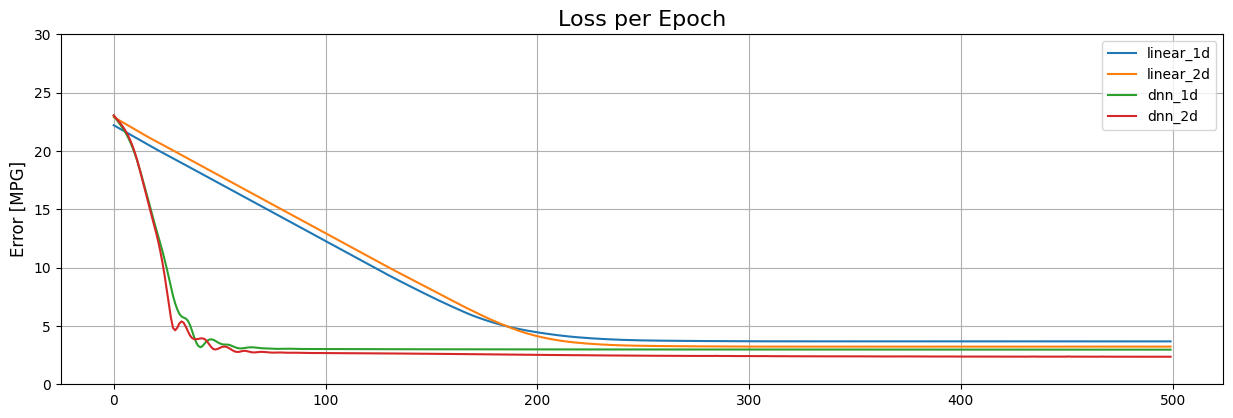

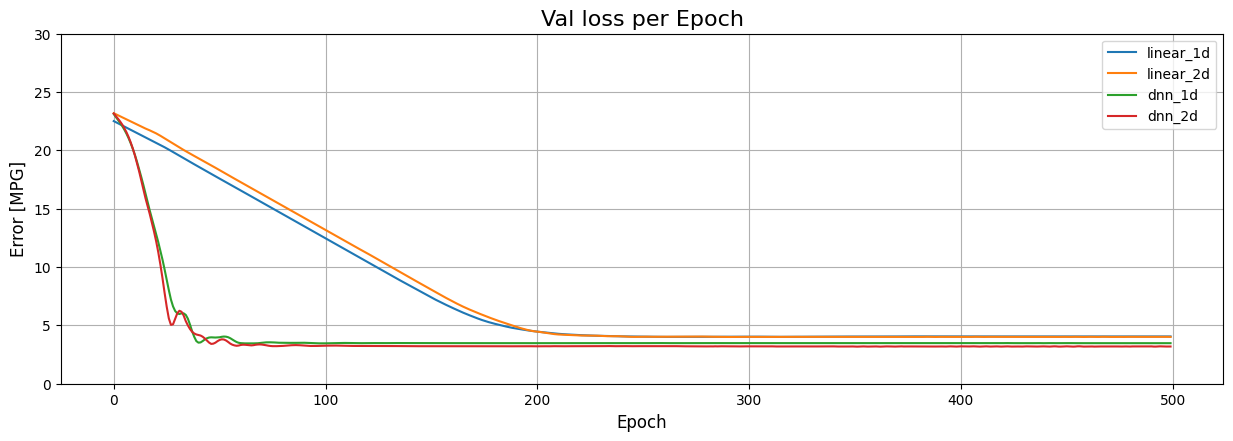

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(loss_curve_train_linear_1d, label="linear_1d")
plt.plot(loss_curve_train_linear_2d, label="linear_2d")
plt.plot(loss_curve_train_dnn_1d,    label="dnn_1d")
plt.plot(loss_curve_train_dnn_2d,    label="dnn_2d")
plt.ylim([0, 30])
plt.ylabel("Error [MPG]")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 2)
plt.plot(loss_curve_eval_linear_1d, label="linear_1d")
plt.plot(loss_curve_eval_linear_2d, label="linear_2d")
plt.plot(loss_curve_eval_dnn_1d,    label="dnn_1d")
plt.plot(loss_curve_eval_dnn_2d,    label="dnn_2d")
plt.ylim([0, 30])
plt.xlabel("Epoch")
plt.ylabel("Error [MPG]")
plt.title("Val loss per Epoch")
plt.legend()
plt.grid(True)

plt.show()
plt.close()

### 7.2 Model Evaluation Comparison

In [ ]:
# Prepare test set.
X_test_hp    = torch.from_numpy(X_test["Horsepower_scaled"].values).reshape(-1, 1).to(torch.float32)
X_test_hp_dp = torch.from_numpy(X_test[["Horsepower_scaled", "Displacement_scaled"]].values).reshape(-1, 2).to(torch.float32)

y_test = torch.from_numpy(y_test.values).reshape(-1, 1).to(torch.float32)

In [ ]:
# Create a dictionary to store test results.
test_results = {}

# Linear regression test results.
with torch.no_grad():
    test_results['linear_1d_model'] = criterion(linear_1d_model(X_test_hp),    y_test).numpy()
    test_results['linear_2d_model'] = criterion(linear_2d_model(X_test_hp_dp), y_test).numpy()

    # Deep learning regression test results.
    test_results['dnn_1d_model'] = criterion(dnn_1d_model(X_test_hp),   y_test).numpy()
    test_results['dnn_2d_model'] = criterion(dnn_2d_model(X_test_hp_dp), y_test).numpy()

In [ ]:
pd.DataFrame(test_results, index=['Mean Absolute Error [MPG]']).T

,Mean Absolute Error [MPG]
linear_1d_model,3.874628
linear_2d_model,3.369334
dnn_1d_model,3.398708
dnn_2d_model,2.759579


### 7.3 Visualizing Model Predictions

Let's now take a look at how well the final model (`dnn_2d_model`) predicts vehicle MPG based on two input features.

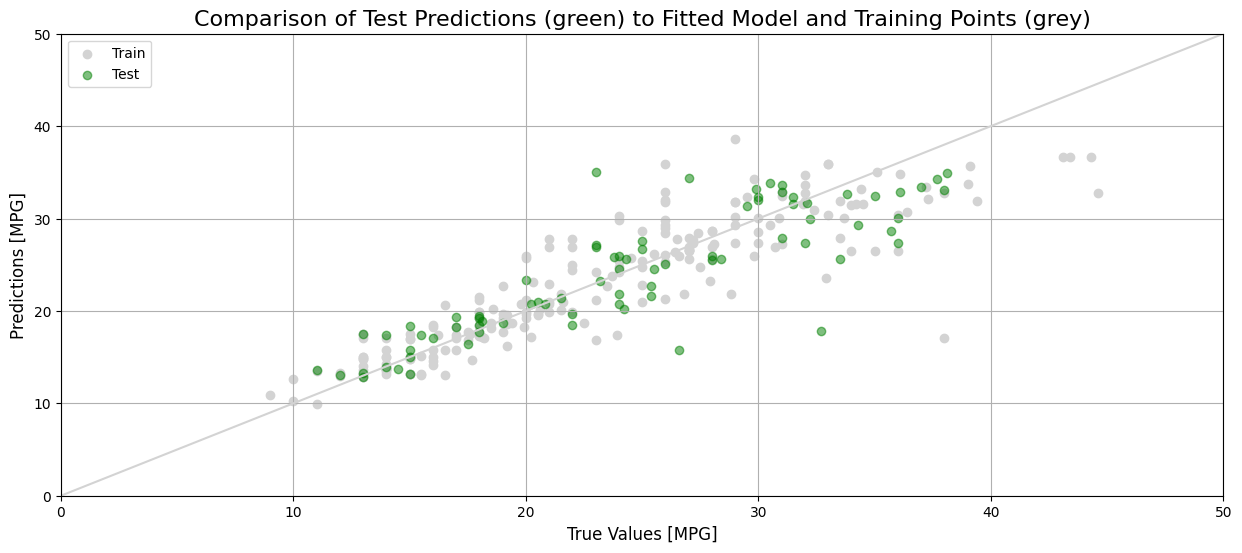

In [ ]:
with torch.no_grad():
    train_predictions = dnn_2d_model(X_train_hp_dp).squeeze()
    test_predictions =  dnn_2d_model(X_test_hp_dp).squeeze()

plt.scatter(y_train_t.numpy(), train_predictions.numpy(), c='lightgray')
plt.scatter(y_test.numpy(),  test_predictions.numpy(),    c='green', alpha=.5)
plt.title('Comparison of Test Predictions (green) to Fitted Model and Training Points (grey)')
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.legend(['Train', 'Test'])
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.grid('on')
plt.plot(lims, lims, c='lightgray');

We can also compute the Mean Absolute Error (MAE) manually from the test data.

In [ ]:
test_error = (test_predictions - y_test.squeeze())
mae = torch.mean(torch.abs(test_error))

print('MAE for dnn_2d_model: ', int(mae * 10000) / 10000)

MAE for dnn_2d_model:  2.7595


### 7.4 Test Error Distribution

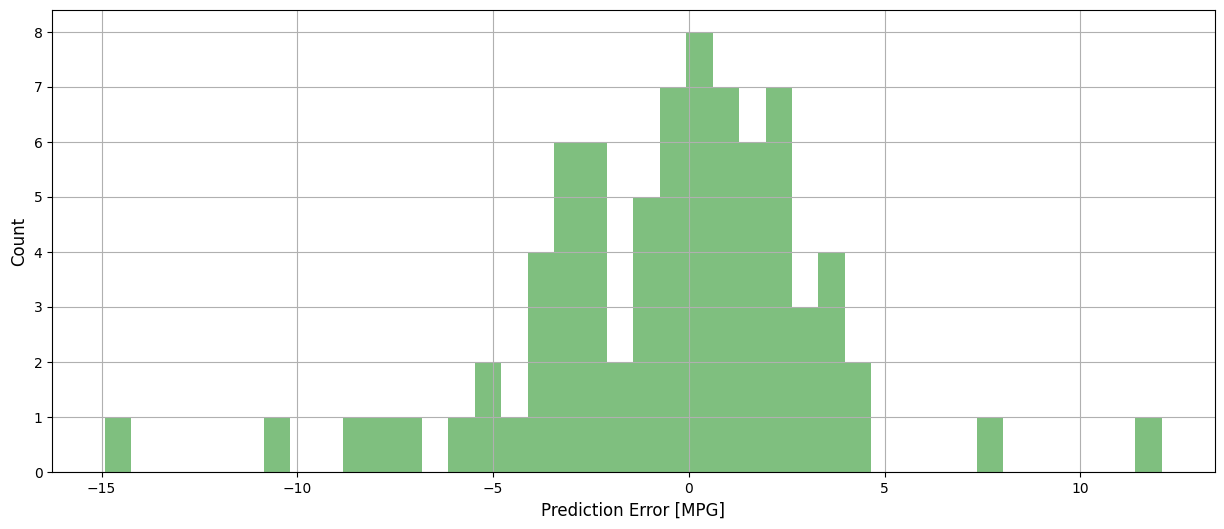

In [ ]:
plt.hist(test_error, bins=40, color='green', alpha=.5)
plt.xlabel('Prediction Error [MPG]')
plt.grid('on')
plt.ylabel('Count');

## 8 Conclusion

In this first part of this notebook, we learned how to model linear regression using a neuron (with a linear activation function), which can be thought of as a simple linear neural network with a single layer (the output layer). We showed that the response from the network is a linear function. We looked at two examples with a single input feature and two input features and showed that these correspond to response functions of a straight line and 2D plane, respectively. In higher dimensions (when the number of features exceeds 2), the response from the linear regression model becomes a hyperplane that cannot be visualized.

Next, we explored the use of hidden layers and non-linear activation functions in a neural network. We showed that this type of architecture allows the network to learn non-linear mappings between the inputs and the output. We showed examples for both a single input feature and two input features to visualize the non-linear response functions. This can easily be extended to using all the features in the dataset. Although it would not be possible to visualize the response function in higher dimensions, you should expect slightly better predictions when using more features. This would be a good exercise to experiment with on your own.